In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


Sedang membaca file...

--- Visualisasi Distribusi Dataset ---


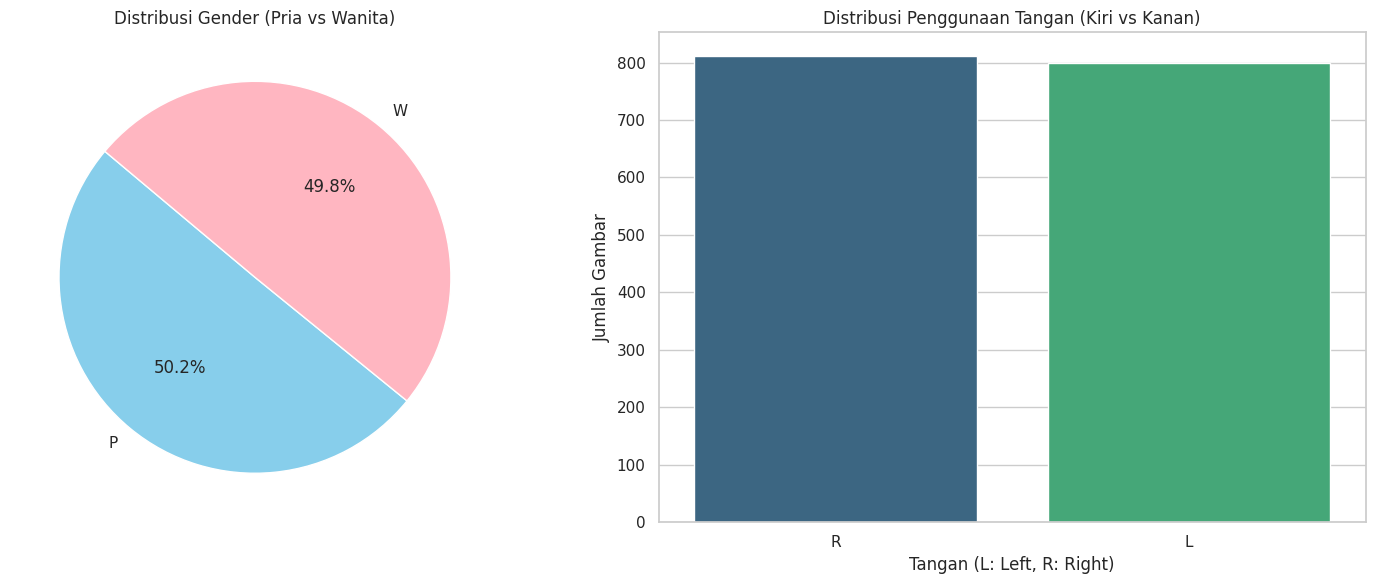

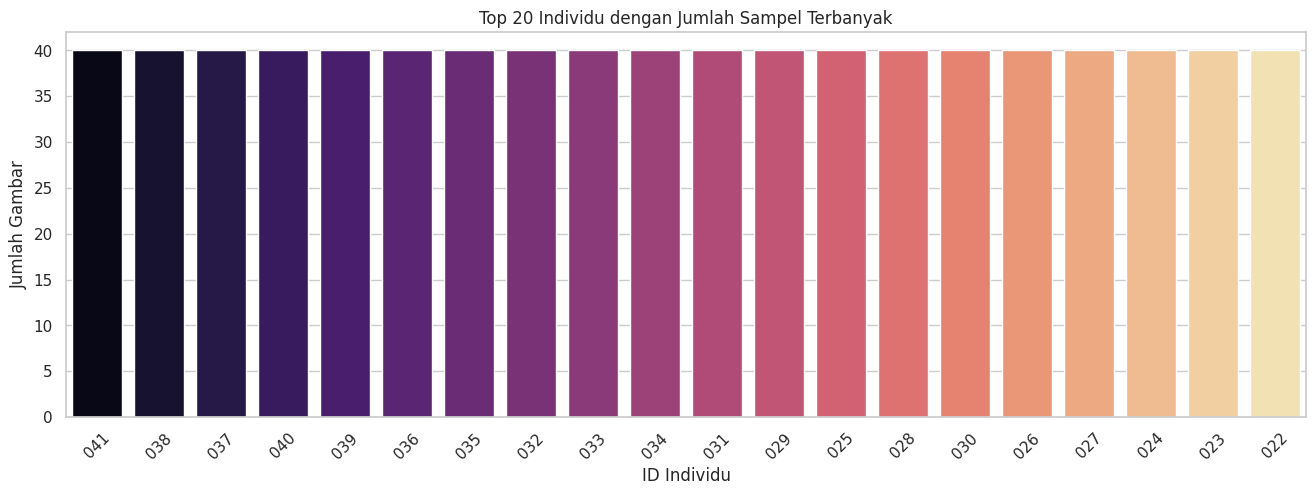


Jumlah Data Training: 1128
Jumlah Data Validasi: 242
Jumlah Data Testing : 242
Total gambar ditemukan: 1612
Total individu unik: 41

Contoh 5 data teratas:
                                           file_path label hand gender
0  /content/drive/MyDrive/Dataset_BMPD/Dataset_BM...   041    R      P
1  /content/drive/MyDrive/Dataset_BMPD/Dataset_BM...   041    L      P
2  /content/drive/MyDrive/Dataset_BMPD/Dataset_BM...   041    R      P
3  /content/drive/MyDrive/Dataset_BMPD/Dataset_BM...   041    L      W
4  /content/drive/MyDrive/Dataset_BMPD/Dataset_BM...   041    R      P


In [ ]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split

# Set gaya visualisasi
sns.set(style="whitegrid")

dataset_dir = r"/content/drive/MyDrive/Dataset_BMPD/Dataset_BMPD"
data = []

print("Sedang membaca file...")
for root, dirs, files in os.walk(dataset_dir):
    for file in files:
        if file.endswith(('.jpg', '.JPG', '.png')):
            file_path = os.path.join(root, file)
            parts = file.split('_')

            if len(parts) >= 4:
                person_id = parts[0]
                gender = parts[1]
                hand = parts[2]

                data.append({
                    'file_path': file_path,
                    'label': person_id,
                    'hand': hand,
                    'gender': gender
                })

df = pd.DataFrame(data)

# PEMETAAN LABEL GENDER (F & S -> M & F)
# Memetakan M (Male) dan F (Female)
df['gender'] = df['gender'].map({'F': 'P', 'S': 'W'})

# VISUALISASI DISTRIBUSI DATASET
print("\n--- Visualisasi Distribusi Dataset ---")

fig, axes = plt.subplots(1, 2, figsize=(15, 6))

# 1. Plot Distribusi Gender (M vs F)
gender_counts = df['gender'].value_counts()
axes[0].pie(gender_counts, labels=gender_counts.index, autopct='%1.1f%%',
        startangle=140, colors=['skyblue', 'lightpink'])
axes[0].set_title('Distribusi Gender (Pria vs Wanita)')

# 2. Plot Distribusi Tangan
hand_counts = df['hand'].value_counts()
sns.barplot(x=hand_counts.index, y=hand_counts.values, ax=axes[1],
            hue=hand_counts.index, palette='viridis', legend=False)
axes[1].set_title('Distribusi Penggunaan Tangan (Kiri vs Kanan)')
axes[1].set_ylabel('Jumlah Gambar')
axes[1].set_xlabel('Tangan (L: Left, R: Right)')

plt.tight_layout()
plt.show()

# 3. Plot Top 20 Individu
plt.figure(figsize=(16, 5))
top_labels = df['label'].value_counts().head(20)
sns.barplot(x=top_labels.index, y=top_labels.values,
            hue=top_labels.index, palette='magma', legend=False)
plt.title('Top 20 Individu dengan Jumlah Sampel Terbanyak')
plt.xlabel('ID Individu')
plt.ylabel('Jumlah Gambar')
plt.xticks(rotation=45)
plt.show()

# RINGKASAN DATA & PEMBAGIAN DATA
# Membagi Data (Train 70%, Val 15%, Test 15%)
X_train, X_temp, y_train, y_temp = train_test_split(
    df, df['label'], test_size=0.3, random_state=42, stratify=df['label']
)

X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp, test_size=0.5, random_state=42, stratify=y_temp
)

# Output yang Anda minta untuk tetap dipertahankan
print(f"\nJumlah Data Training: {len(X_train)}")
print(f"Jumlah Data Validasi: {len(X_val)}")
print(f"Jumlah Data Testing : {len(X_test)}")
print(f"Total gambar ditemukan: {len(df)}")
print(f"Total individu unik: {df['label'].nunique()}")

print("\nContoh 5 data teratas:")
print(df.head())

In [ ]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Cek versi TensorFlow (Optional, untuk debugging)
print(f"TensorFlow Version: {tf.__version__}")

# --- KONFIGURASI ---
BATCH_SIZE = 32
IMG_HEIGHT = 224
IMG_WIDTH = 224

# --- 1. DEFINISI AUGMENTASI (Perbaikan 'not defined') ---
# Kita definisikan dulu 'alat' pembuat datanya
train_datagen = ImageDataGenerator(
    rescale=1./255,         # Normalisasi pixel ke 0-1
    rotation_range=20,      # Rotasi gambar
    width_shift_range=0.2,  # Geser kiri-kanan
    height_shift_range=0.2, # Geser atas-bawah
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=False,  # Jangan flip horizontal (karena L beda dengan R)
    fill_mode='nearest'
)

# Untuk validasi dan test, hanya rescale saja (jangan diacak-acak gambarnya)
val_test_datagen = ImageDataGenerator(rescale=1./255)


# --- 2. MEMBUAT GENERATOR (FLOW FROM DATAFRAME) ---
print("\nMenyiapkan Generator Data...")

# Generator Training
train_generator = train_datagen.flow_from_dataframe(
    dataframe=X_train,       # Menggunakan variabel X_train dari langkah sebelumnya
    x_col='file_path',       # Kolom lokasi gambar
    y_col='label',           # Kolom ID orang
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=True
)

# Generator Validation
val_generator = val_test_datagen.flow_from_dataframe(
    dataframe=X_val,
    x_col='file_path',
    y_col='label',
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=False
)

# Generator Testing
test_generator = val_test_datagen.flow_from_dataframe(
    dataframe=X_test,
    x_col='file_path',
    y_col='label',
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=False
)

TensorFlow Version: 2.19.0

Menyiapkan Generator Data...
Found 1128 validated image filenames belonging to 41 classes.
Found 242 validated image filenames belonging to 41 classes.
Found 242 validated image filenames belonging to 41 classes.


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ mobilenetv2_1.00_224            │ (None, 7, 7, 1280)     │     2,257,984 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_2      │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 128)            │       163,968 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 41)             │         5,289 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,427,241 (9.26 MB)

 Trainable params: 169,257 (661.16 KB)

 Non-trainable params: 2,257,984 (8.61 MB)


Mulai Training Model Klasifikasi...
Epoch 1/20
36/36 ━━━━━━━━━━━━━━━━━━━━ 156s 4s/step - accuracy: 0.0657 - loss: 3.7345 - val_accuracy: 0.2314 - val_loss: 2.9301
Epoch 2/20
36/36 ━━━━━━━━━━━━━━━━━━━━ 159s 4s/step - accuracy: 0.2927 - loss: 2.8019 - val_accuracy: 0.5537 - val_loss: 2.0988
Epoch 3/20
36/36 ━━━━━━━━━━━━━━━━━━━━ 139s 4s/step - accuracy: 0.4490 - loss: 2.1583 - val_accuracy: 0.5992 - val_loss: 1.6277
Epoch 4/20
36/36 ━━━━━━━━━━━━━━━━━━━━ 147s 4s/step - accuracy: 0.5791 - loss: 1.6362 - val_accuracy: 0.7603 - val_loss: 1.2381
Epoch 5/20
36/36 ━━━━━━━━━━━━━━━━━━━━ 141s 4s/step - accuracy: 0.6742 - loss: 1.3264 - val_accuracy: 0.8264 - val_loss: 0.9677
Epoch 6/20
36/36 ━━━━━━━━━━━━━━━━━━━━ 158s 4s/step - accuracy: 0.7096 - loss: 1.1298 - val_accuracy: 0.8719 - val_loss: 0.7763
Epoch 7/20
36/36 ━━━━━━━━━━━━━━━━━━━━ 140s 4s/step - accuracy: 0.7683 - loss: 0.9434 - val_accuracy: 0.8719 - val_loss: 0.6817
Epoch 8/20
36/36 ━━━━━━━━━━━━━━━━━━━━ 149s 4s/step - accuracy: 0.7821 - lo

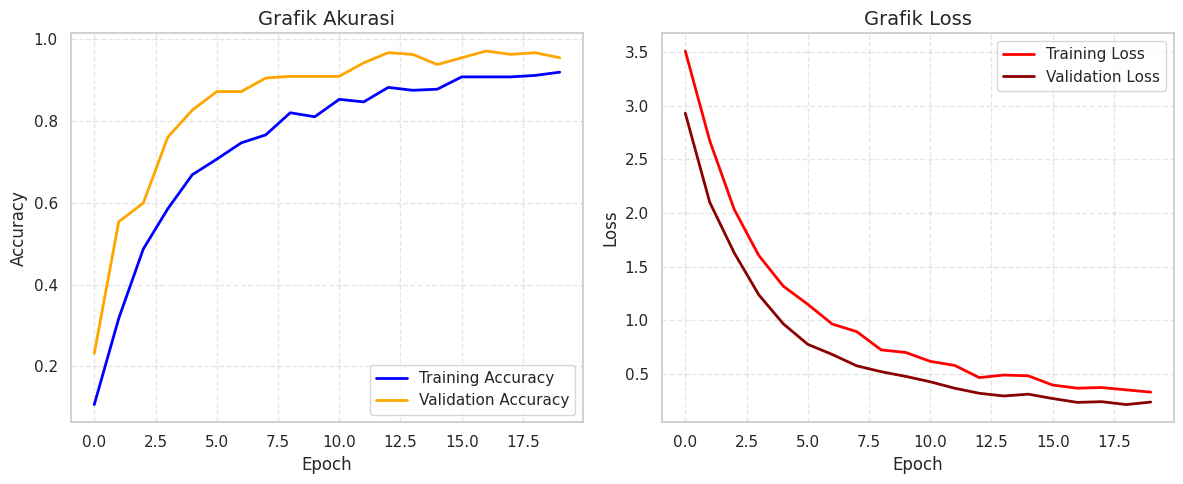

In [ ]:
import matplotlib.pyplot as plt
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping

# 1. Load Pre-trained Model (MobileNetV2)
base_model = MobileNetV2(
    input_shape=(224, 224, 3),
    include_top=False,
    weights='imagenet'
)

# Bekukan base model agar fitur dasar ImageNet tidak berubah
base_model.trainable = False

# 2. Bangun Arsitektur Model (Sesuai model_summary Anda)
model_clf = Sequential([
    base_model,
    GlobalAveragePooling2D(),
    Dense(128, activation='relu'),
    Dropout(0.2),
    Dense(41, activation='softmax')
])

# 3. Compile Model
model_clf.compile(
    optimizer=Adam(learning_rate=0.001),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# Menampilkan kembali summary untuk memastikan struktur tidak berubah
model_clf.summary()

# 4. Latih Model (Training)
early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

print("\nMulai Training Model Klasifikasi...")
history = model_clf.fit(
    train_generator,
    epochs=20,
    validation_data=val_generator,
    callbacks=[early_stop]
)

# PENAMBAHAN MATPLOTLIB: GRAFIK EVALUASI
print("\n--- Visualisasi Performa Model Klasifikasi ---")
plt.figure(figsize=(12, 5))

# Plot Akurasi
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy', color='blue', linewidth=2)
plt.plot(history.history['val_accuracy'], label='Validation Accuracy', color='orange', linewidth=2)
plt.title('Grafik Akurasi', fontsize=14)
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.5)

# Plot Loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss', color='red', linewidth=2)
plt.plot(history.history['val_loss'], label='Validation Loss', color='darkred', linewidth=2)
plt.title('Grafik Loss', fontsize=14)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.5)

plt.tight_layout()
plt.show()

Sedang mengevaluasi data testing...
8/8 ━━━━━━━━━━━━━━━━━━━━ 67s 9s/step - accuracy: 0.9703 - loss: 0.1998



Final Test Accuracy: 97.11%
Model berhasil disimpan sebagai 'model_klasifikasi_telapak.h5'

Mengambil prediksi model...
8/8 ━━━━━━━━━━━━━━━━━━━━ 25s 3s/step

Menampilkan Confusion Matrix Heatmap...


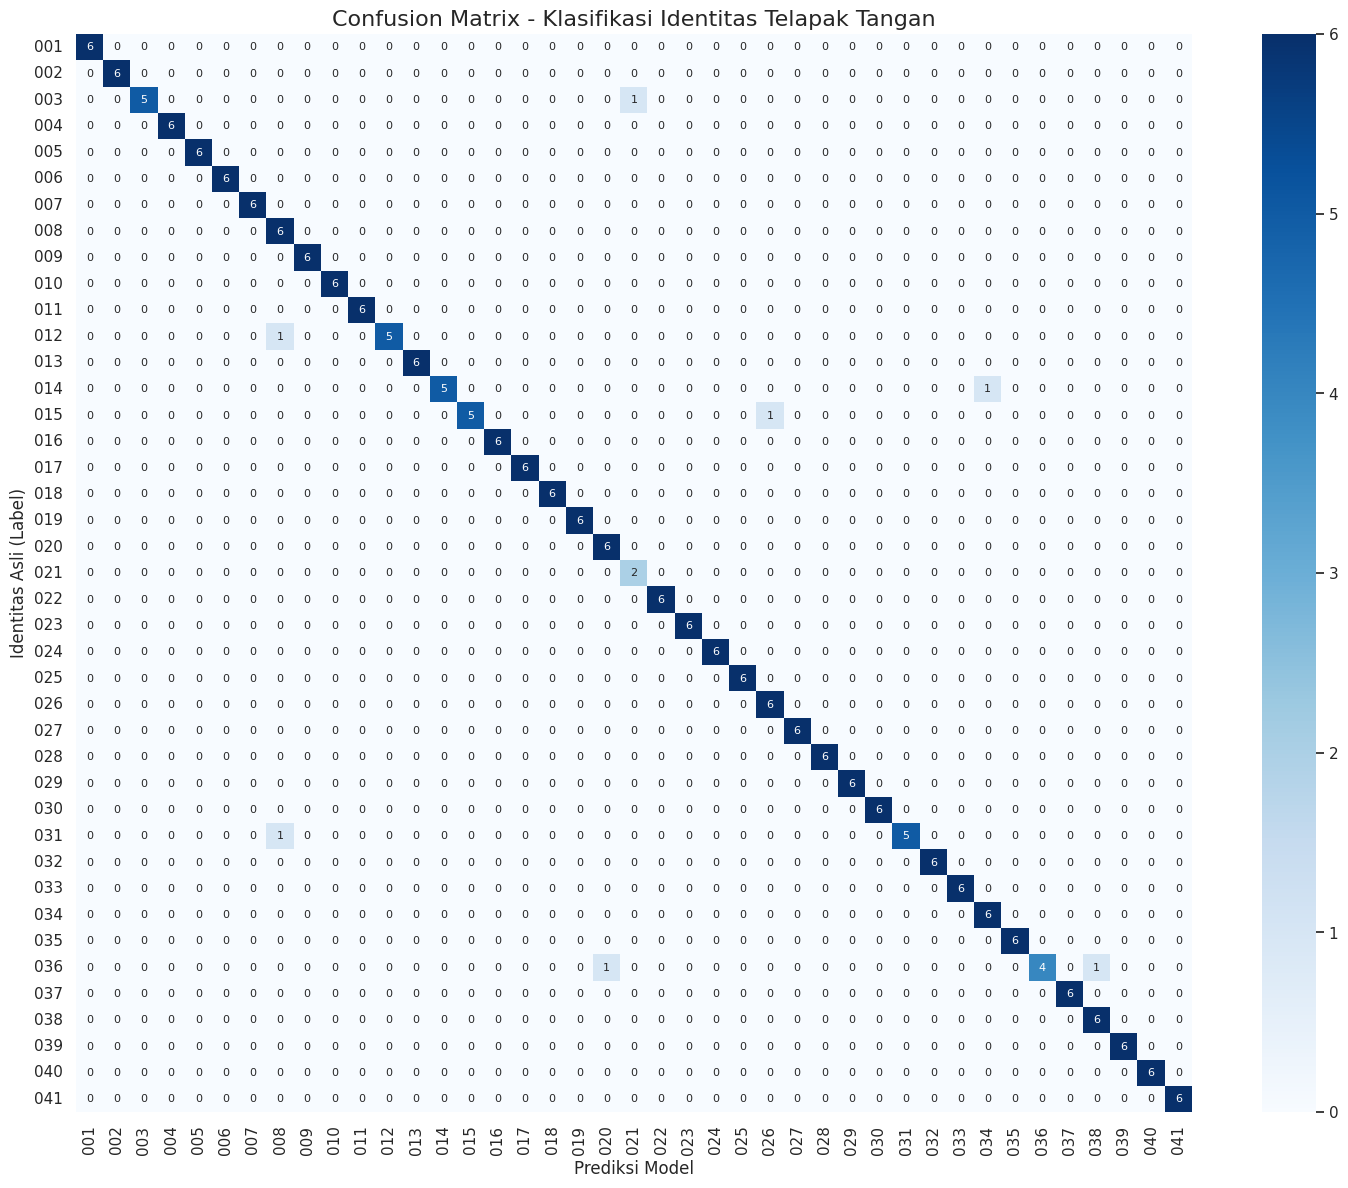


Classification Report:
              precision    recall  f1-score   support

         001       1.00      1.00      1.00         6
         002       1.00      1.00      1.00         6
         003       1.00      0.83      0.91         6
         004       1.00      1.00      1.00         6
         005       1.00      1.00      1.00         6
         006       1.00      1.00      1.00         6
         007       1.00      1.00      1.00         6
         008       0.75      1.00      0.86         6
         009       1.00      1.00      1.00         6
         010       1.00      1.00      1.00         6
         011       1.00      1.00      1.00         6
         012       1.00      0.83      0.91         6
         013       1.00      1.00      1.00         6
         014       1.00      0.83      0.91         6
         015       1.00      0.83      0.91         6
         016       1.00      1.00      1.00         6
         017       1.00      1.00      1.00         6
   

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix

# 1. Evaluasi pada Data Test (Final Check)
print("Sedang mengevaluasi data testing...")
test_loss, test_acc = model_clf.evaluate(test_generator)
print(f"\nFinal Test Accuracy: {test_acc*100:.2f}%")

# 2. Simpan Model
model_clf.save("model_klasifikasi_telapak.h5")
print("Model berhasil disimpan sebagai 'model_klasifikasi_telapak.h5'")

# 3. Ambil prediksi model untuk analisis mendalam
print("\nMengambil prediksi model...")
predictions = model_clf.predict(test_generator)
y_pred = np.argmax(predictions, axis=1)
y_true = test_generator.classes
class_labels = list(test_generator.class_indices.keys())

# --- VISUALISASI CONFUSION MATRIX (MATPLOTLIB & SEABORN) ---
print("\nMenampilkan Confusion Matrix Heatmap...")
cm = confusion_matrix(y_true, y_pred)

# Kita buat ukuran figure yang besar (18x14) karena ada 41 kelas
plt.figure(figsize=(18, 14))
sns.heatmap(
    cm,
    annot=True,                 # Menampilkan angka di dalam kotak
    fmt='d',                    # Format angka sebagai integer (desimal)
    cmap='Blues',               # Warna biru (semakin gelap semakin banyak jumlahnya)
    xticklabels=class_labels,
    yticklabels=class_labels,
    annot_kws={"size": 8}       # Ukuran font angka diperkecil agar pas di kotak
)

plt.title('Confusion Matrix - Klasifikasi Identitas Telapak Tangan', fontsize=16)
plt.ylabel('Identitas Asli (Label)', fontsize=12)
plt.xlabel('Prediksi Model', fontsize=12)
plt.xticks(rotation=90)         # Putar label ID di sumbu X agar terbaca jelas
plt.show()

# --- Tampilkan Report Lengkap ---
print("\nClassification Report:")
print(classification_report(y_true, y_pred, target_names=class_labels))

In [ ]:
import numpy as np
import cv2 # Library OpenCV untuk baca gambar
import random
from tensorflow.keras.preprocessing.image import img_to_array, load_img

# Fungsi untuk memuat gambar dan mengubahnya jadi array
def read_image(file_path):
    # Load gambar, resize ke 128x128, convert ke array
    img = load_img(file_path, target_size=(128, 128))
    img = img_to_array(img)
    img = img / 255.0  # Normalisasi (0-1)
    return img

def make_pairs(dataframe):
    """
    Membuat pasangan data langsung dari DataFrame.
    Input: dataframe (harus punya kolom 'file_path' dan 'label')
    """
    # Kita copy agar tidak mengganggu data asli
    df_temp = dataframe.copy()

    # Dapatkan list unik setiap orang untuk sampling negatif
    unique_ids = df_temp['label'].unique()

    pairs = []
    labels = []

    # Dictionary: ID -> List of file_paths
    # Ini mempercepat pencarian gambar positif/negatif
    person_images = {pid: df_temp[df_temp['label'] == pid]['file_path'].values for pid in unique_ids}

    print(f"Membuat pasangan dari {len(df_temp)} baris data...")

    counter = 0
    # Loop melalui setiap baris data
    for i, row in df_temp.iterrows():
        try:
            current_img_path = row['file_path']
            current_label = row['label']

            # --- Load Anchor Image ---
            img_anchor = load_img(current_img_path, target_size=(128, 128))
            img_anchor = img_to_array(img_anchor) / 255.0

            # --- 1. Positive Pair (Gambar SAMA) ---
            # Ambil acak gambar lain dari orang yang sama
            pos_img_path = random.choice(person_images[current_label])
            img_pos = load_img(pos_img_path, target_size=(128, 128))
            img_pos = img_to_array(img_pos) / 255.0

            pairs.append([img_anchor, img_pos])
            labels.append(1.0) # 1 = Sama

            # --- 2. Negative Pair (Gambar BEDA) ---
            # Cari label orang lain
            neg_label = current_label
            while neg_label == current_label:
                neg_label = random.choice(unique_ids)

            neg_img_path = random.choice(person_images[neg_label])
            img_neg = load_img(neg_img_path, target_size=(128, 128))
            img_neg = img_to_array(img_neg) / 255.0

            pairs.append([img_anchor, img_neg])
            labels.append(0.0) # 0 = Beda

            # Print progress setiap 200 data biar tahu jalan atau tidak
            counter += 1
            if counter % 200 == 0:
                print(f"  Processed {counter} images...")

        except Exception as e:
            print(f"Error pada file {current_img_path}: {e}")
            continue

    return np.array(pairs), np.array(labels).astype('float32')

# --- EKSEKUSI (Cukup masukkan X_train dan X_test saja) ---

print("--- Memproses Data Training ---")
# Perhatikan: Kita hanya memasukkan X_train (karena labelnya sudah ada di dalamnya)
pairs_train, labels_train = make_pairs(X_train)

print("\n--- Memproses Data Testing ---")
pairs_test, labels_test = make_pairs(X_test)

print("\n--- Selesai ---")
print(f"Ukuran Pasangan Training: {pairs_train.shape}")
print(f"Ukuran Pasangan Testing : {pairs_test.shape}")

--- Memproses Data Training ---
Membuat pasangan dari 1128 baris data...
  Processed 200 images...
  Processed 400 images...
  Processed 600 images...
  Processed 800 images...
  Processed 1000 images...

--- Memproses Data Testing ---
Membuat pasangan dari 242 baris data...
  Processed 200 images...

--- Selesai ---
Ukuran Pasangan Training: (2256, 2, 128, 128, 3)
Ukuran Pasangan Testing : (484, 2, 128, 128, 3)


Model: "siamese_network"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ left_input          │ (None, 128, 128,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ right_input         │ (None, 128, 128,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding_network   │ (None, 128)       │  6,548,928 │ left_input[0][0], │
│ (Sequential)        │                   │            │ right_input[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ distance_layer      │ (None, 1)         │          0 │ embedding_networ… │
│ (Lambda)            │                   │            │ embedding_networ… │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 6,548,928 (24.98 MB)

 Trainable params: 6,548,928 (24.98 MB)

 Non-trainable params: 0 (0.00 B)


Mulai Training Siamese Network...
Epoch 1/20
71/71 ━━━━━━━━━━━━━━━━━━━━ 173s 2s/step - loss: 0.2254 - val_loss: 0.2767
Epoch 2/20
71/71 ━━━━━━━━━━━━━━━━━━━━ 195s 2s/step - loss: 0.1721 - val_loss: 0.2264
Epoch 3/20
71/71 ━━━━━━━━━━━━━━━━━━━━ 162s 2s/step - loss: 0.1277 - val_loss: 0.1775
Epoch 4/20
71/71 ━━━━━━━━━━━━━━━━━━━━ 163s 2s/step - loss: 0.1002 - val_loss: 0.1652
Epoch 5/20
71/71 ━━━━━━━━━━━━━━━━━━━━ 203s 2s/step - loss: 0.0891 - val_loss: 0.1329
Epoch 6/20
71/71 ━━━━━━━━━━━━━━━━━━━━ 203s 2s/step - loss: 0.0685 - val_loss: 0.1014
Epoch 7/20
71/71 ━━━━━━━━━━━━━━━━━━━━ 164s 2s/step - loss: 0.0559 - val_loss: 0.0898
Epoch 8/20
71/71 ━━━━━━━━━━━━━━━━━━━━ 201s 2s/step - loss: 0.0458 - val_loss: 0.0945
Epoch 9/20
71/71 ━━━━━━━━━━━━━━━━━━━━ 202s 2s/step - loss: 0.0407 - val_loss: 0.0937
Epoch 10/20
71/71 ━━━━━━━━━━━━━━━━━━━━ 200s 2s/step - loss: 0.0401 - val_loss: 0.0822
Epoch 11/20
71/71 ━━━━━━━━━━━━━━━━━━━━ 159s 2s/step - loss: 0.0313 - val_loss: 0.0815
Epoch 12/20
71/71 ━━━━━━━━━━

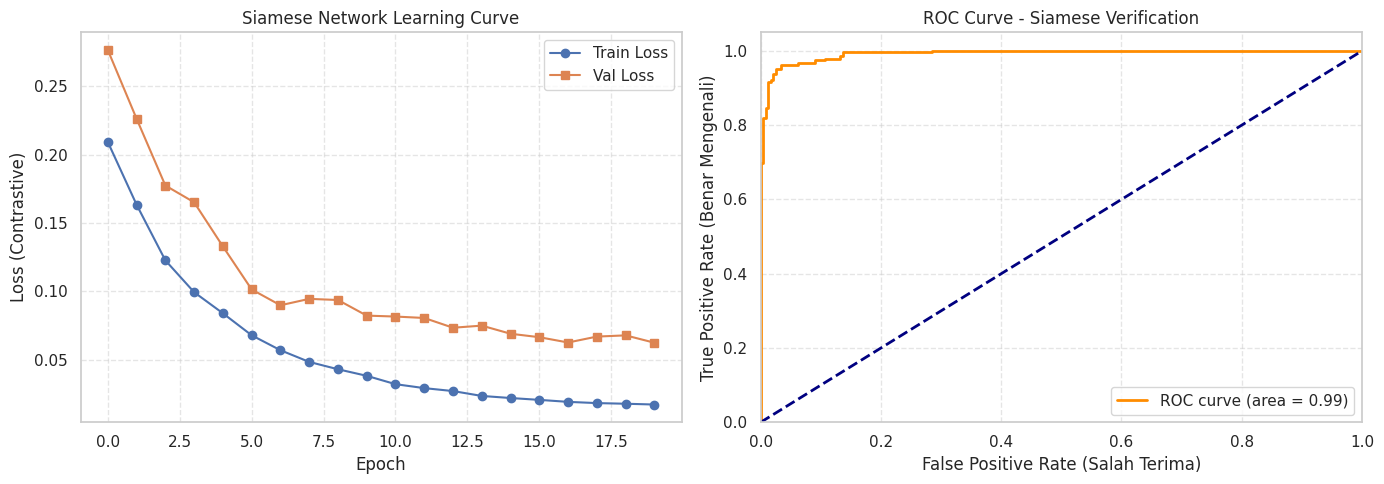

In [ ]:
import matplotlib.pyplot as plt
import tensorflow.keras.backend as K
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Input, Flatten, Dense, Dropout, Lambda, Conv2D, MaxPooling2D
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import roc_curve, auc

# 1. Fungsi Jarak (Euclidean Distance)
def euclidean_distance(vects):
    x, y = vects
    sum_square = K.sum(K.square(x - y), axis=1, keepdims=True)
    return K.sqrt(K.maximum(sum_square, K.epsilon()))

# 2. Embedding Network (Feature Extractor)
def build_embedding_network(input_shape):
    model = Sequential([
        Input(shape=input_shape),
        Conv2D(32, (3, 3), activation='relu'),
        MaxPooling2D((2, 2)),
        Dropout(0.2),
        Conv2D(64, (3, 3), activation='relu'),
        MaxPooling2D((2, 2)),
        Dropout(0.2),
        Conv2D(128, (3, 3), activation='relu'),
        MaxPooling2D((2, 2)),
        Flatten(),
        Dense(256, activation='relu'),
        Dense(128, activation=None)
    ], name="embedding_network")
    return model

# 3. Fungsi Contrastive Loss
def contrastive_loss(y_true, y_pred):
    margin = 1.0
    square_pred = K.square(y_pred)
    margin_square = K.square(K.maximum(margin - y_pred, 0))
    return K.mean(y_true * square_pred + (1 - y_true) * margin_square)

# --- MERAKIT SIAMESE NETWORK ---
input_shape = (128, 128, 3)
input_a = Input(shape=input_shape, name="left_input")
input_b = Input(shape=input_shape, name="right_input")

embedding_net = build_embedding_network(input_shape)
feat_a = embedding_net(input_a)
feat_b = embedding_net(input_b)

distance = Lambda(euclidean_distance, name="distance_layer")([feat_a, feat_b])
model_siamese = Model(inputs=[input_a, input_b], outputs=distance, name="siamese_network")

# Compile Model
model_siamese.compile(loss=contrastive_loss, optimizer=Adam(learning_rate=0.0005))

# Menampilkan Summary Arsitektur
model_siamese.summary()

# Persiapan Data Input
img_a_train = pairs_train[:, 0]
img_b_train = pairs_train[:, 1]
img_a_test = pairs_test[:, 0]
img_b_test = pairs_test[:, 1]

# --- PROSES TRAINING ---
print("\nMulai Training Siamese Network...")
history_siamese = model_siamese.fit(
    [img_a_train, img_b_train],
    labels_train,
    validation_data=([img_a_test, img_b_test], labels_test),
    batch_size=32,
    epochs=20
)

# --- VISUALISASI HASIL (LOSS & ROC CURVE) ---
print("\nTraining Selesai. Menampilkan Analisis Performa...")

plt.figure(figsize=(14, 5))

# A. Plot Loss Curve
plt.subplot(1, 2, 1)
plt.plot(history_siamese.history['loss'], label='Train Loss', marker='o')
plt.plot(history_siamese.history['val_loss'], label='Val Loss', marker='s')
plt.title('Siamese Network Learning Curve')
plt.xlabel('Epoch')
plt.ylabel('Loss (Contrastive)')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.5)

# B. Plot ROC Curve
# Prediksi jarak (Distance)
dist_pred = model_siamese.predict([img_a_test, img_b_test])
# Konversi jarak ke skor kemiripan (makin besar makin mirip)
y_scores = 1.0 - dist_pred.ravel()

fpr, tpr, thresholds = roc_curve(labels_test, y_scores)
roc_auc = auc(fpr, tpr)

plt.subplot(1, 2, 2)
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:0.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate (Salah Terima)')
plt.ylabel('True Positive Rate (Benar Mengenali)')
plt.title('ROC Curve - Siamese Verification')
plt.legend(loc="lower right")
plt.grid(True, linestyle='--', alpha=0.5)

plt.tight_layout()
plt.show()

Model Siamese berhasil disimpan!

Sedang memprediksi jarak pada data test...
16/16 ━━━━━━━━━━━━━━━━━━━━ 10s 628ms/step

--- HASIL AKHIR VERIFIKASI ---
Akurasi Siamese Network: 95.87%


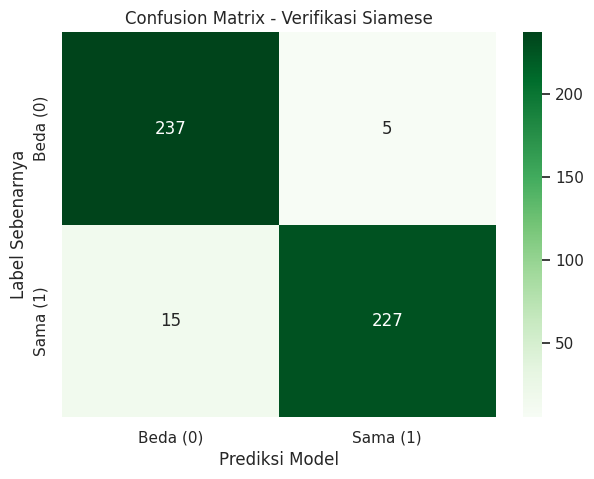



SAMPEL TELAPAK TANGAN (VERIFIKASI)


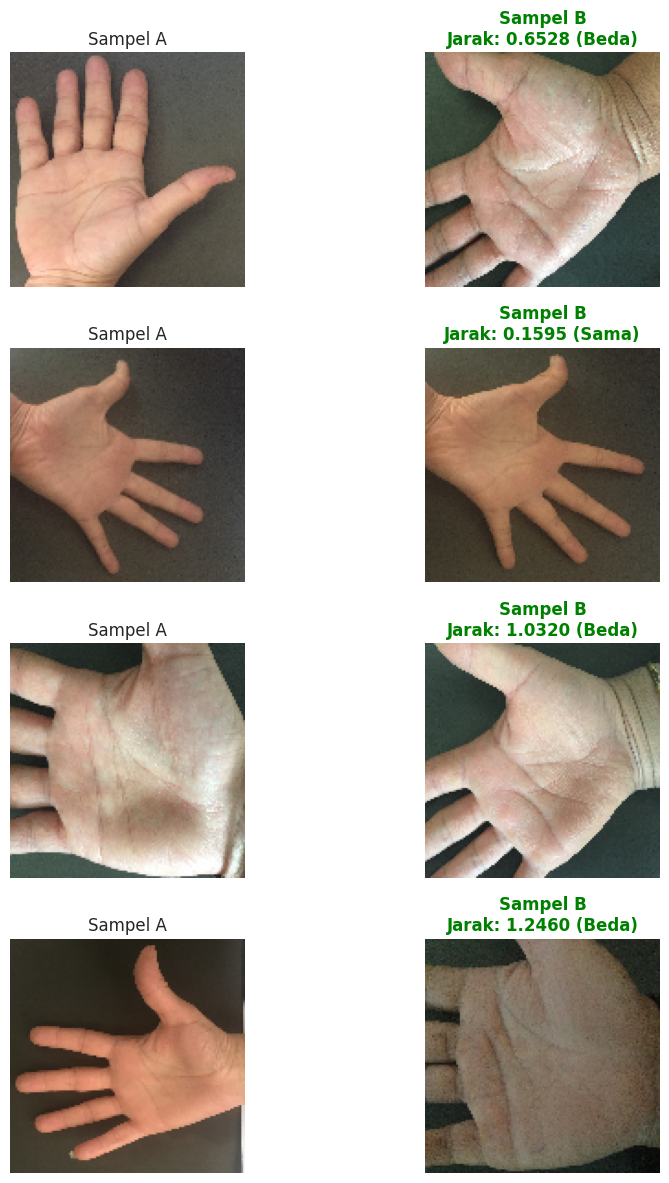

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

# 1. Simpan Model Siamese
model_siamese.save("model_siamese_telapak.h5")
print("Model Siamese berhasil disimpan!\n")

# 2. Lakukan Prediksi pada Data Test
print("Sedang memprediksi jarak pada data test...")
predictions = model_siamese.predict([img_a_test, img_b_test])

# 3. Evaluasi & Matriks (Heatmap)
threshold = 0.5
y_pred = (predictions.ravel() < threshold).astype(int)
y_true = labels_test

print(f"\n--- HASIL AKHIR VERIFIKASI ---")
print(f"Akurasi Siamese Network: {accuracy_score(y_true, y_pred)*100:.2f}%")

# Plot Confusion Matrix
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(7, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Greens',
            xticklabels=['Beda (0)', 'Sama (1)'],
            yticklabels=['Beda (0)', 'Sama (1)'])
plt.title('Confusion Matrix - Verifikasi Siamese')
plt.xlabel('Prediksi Model')
plt.ylabel('Label Sebenarnya')
plt.show()

print("\n")
print("SAMPEL TELAPAK TANGAN (VERIFIKASI)")

# 4. Visualisasi Hasil (DEMO SEDERHANA)
def visualize_results(img_a, img_b, preds, true_labels):
    fig, axes = plt.subplots(4, 2, figsize=(10, 12))
    indices = np.random.choice(len(img_a), 4, replace=False)

    for i, idx in enumerate(indices):
        dist = preds[idx][0]
        label = true_labels[idx]

        # Penentuan status teks berdasarkan label asli
        status = "Sama" if label == 1 else "Beda"

        # Penentuan warna (Hijau jika prediksi benar, Merah jika salah)
        pred_label = 1 if dist < 0.5 else 0
        text_color = 'green' if pred_label == label else 'red'

        # Subplot Sampel A
        axes[i, 0].imshow(img_a[idx])
        axes[i, 0].set_title("Sampel A", fontsize=12)
        axes[i, 0].axis('off')

        # Subplot Sampel B dengan informasi Jarak dan Status
        axes[i, 1].imshow(img_b[idx])
        axes[i, 1].set_title(f"Sampel B\nJarak: {dist:.4f} ({status})",
                             color=text_color, fontsize=12, fontweight='bold')
        axes[i, 1].axis('off')

    plt.tight_layout()
    plt.show()

# Jalankan Demo
visualize_results(img_a_test, img_b_test, predictions, labels_test)

In [ ]:
# Ambil dictionary label dari generator yang sudah dibuat
labels_map = (train_generator.class_indices)
# Balik kuncinya agar kita bisa cari Nama berdasarkan Angka
# Contoh: {0: '001', 1: '002', ...}
labels_map_inv = {v: k for k, v in labels_map.items()}

print("Mapping Label siap!")
print(f"Contoh: ID 0 adalah {labels_map_inv[0]}")

Mapping Label siap!
Contoh: ID 0 adalah 001


In [ ]:
import matplotlib.pyplot as plt
import numpy as np
from tensorflow.keras.preprocessing.image import load_img, img_to_array

def analisis_lengkap(path_img_a, path_img_b):
    # --- 1. PREPROCESSING ---
    # Load gambar untuk Model Klasifikasi (Butuh 224x224)
    img_a_clf = load_img(path_img_a, target_size=(224, 224))
    img_b_clf = load_img(path_img_b, target_size=(224, 224))

    # Ubah ke array & Normalisasi
    x_a_clf = img_to_array(img_a_clf) / 255.0
    x_b_clf = img_to_array(img_b_clf) / 255.0

    # Tambah dimensi batch (dari (224,224,3) jadi (1,224,224,3))
    x_a_clf = np.expand_dims(x_a_clf, axis=0)
    x_b_clf = np.expand_dims(x_b_clf, axis=0)

    # Load gambar untuk Model Siamese (Butuh 128x128)
    img_a_siam = load_img(path_img_a, target_size=(128, 128))
    img_b_siam = load_img(path_img_b, target_size=(128, 128))

    x_a_siam = img_to_array(img_a_siam) / 255.0
    x_b_siam = img_to_array(img_b_siam) / 255.0

    x_a_siam = np.expand_dims(x_a_siam, axis=0)
    x_b_siam = np.expand_dims(x_b_siam, axis=0)

    # --- 2. PREDIKSI MODEL KLASIFIKASI ---
    # Prediksi A
    pred_a = model_clf.predict(x_a_clf)
    class_a = np.argmax(pred_a)
    prob_a = np.max(pred_a)
    label_a = labels_map_inv[class_a]

    # Prediksi B
    pred_b = model_clf.predict(x_b_clf)
    class_b = np.argmax(pred_b)
    prob_b = np.max(pred_b)
    label_b = labels_map_inv[class_b]

    # --- 3. PREDIKSI MODEL SIAMESE ---
    dist = model_siamese.predict([x_a_siam, x_b_siam])[0][0]
    is_same = dist < 0.5  # Threshold
    status_verif = "ASLI/SAMA" if is_same else "PALSU/BEDA"
    color_verif = "green" if is_same else "red"

    # --- 4. VISUALISASI LAPORAN ---
    fig, ax = plt.subplots(1, 2, figsize=(10, 5))

    # Plot Gambar A
    ax[0].imshow(img_a_clf)
    ax[0].set_title(f"Gambar A\nPrediksi Klasifikasi: {label_a}\nConf: {prob_a*100:.2f}%")
    ax[0].axis('off')

    # Plot Gambar B
    ax[1].imshow(img_b_clf)
    ax[1].set_title(f"Gambar B\nPrediksi Klasifikasi: {label_b}\nConf: {prob_b*100:.2f}%")
    ax[1].axis('off')

    # Judul Tengah (Hasil Verifikasi)
    plt.suptitle(f"Hasil Verifikasi Siamese Network\nJarak: {dist:.4f} -> Keputusan: {status_verif}",
                 fontsize=14, color=color_verif, fontweight='bold')

    plt.tight_layout()
    plt.show()



1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step


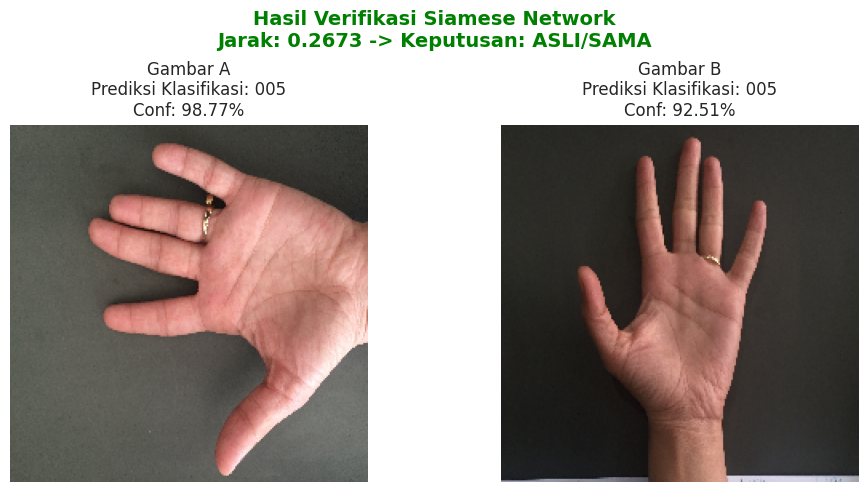

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 93ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step


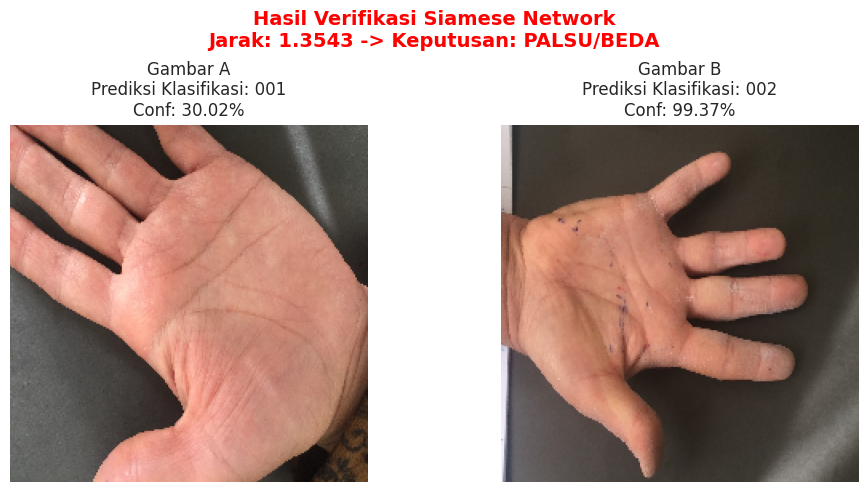

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step


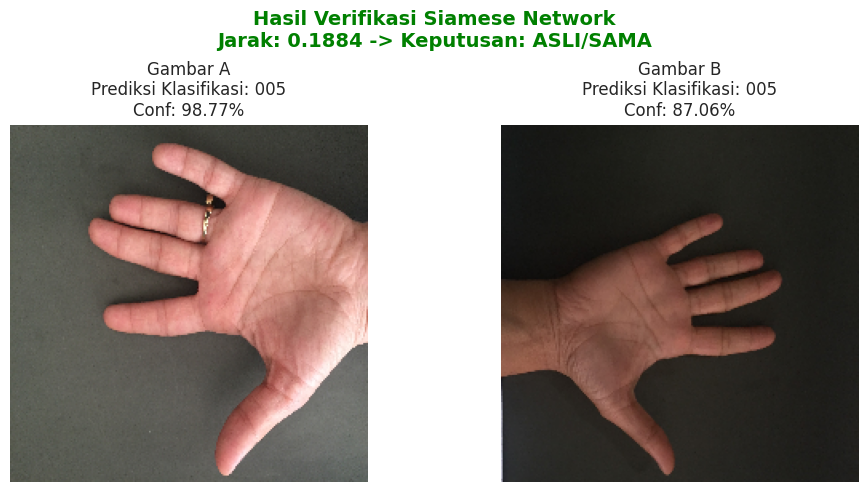

In [ ]:
# orang yang sama dengan tangan yang sama
file_1 = r"/content/drive/MyDrive/Dataset_BMPD/Dataset_BMPD/005/005_F_L_30.JPG"
file_2 = r"/content/drive/MyDrive/Dataset_BMPD/Dataset_BMPD/005/005_F_L_35.JPG"

analisis_lengkap(file_1, file_2)
# orang yang berbeda
file_3 = r"/content/drive/MyDrive/Dataset_BMPD/Dataset_BMPD/001/001_F_L_30.JPG"
file_4 = r"/content/drive/MyDrive/Dataset_BMPD/Dataset_BMPD/002/002_F_R_5.JPG"

analisis_lengkap(file_3, file_4)
#orang sama beda sisi tangan , tangan kanan dan kiri
file_5 = r"/content/drive/MyDrive/Dataset_BMPD/Dataset_BMPD/005/005_F_L_30.JPG"
file_6 = r"/content/drive/MyDrive/Dataset_BMPD/Dataset_BMPD/005/005_F_R_1.JPG"

analisis_lengkap(file_5, file_6)

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import random
from tensorflow.keras.preprocessing.image import load_img, img_to_array

# ==========================================
# BAGIAN 1: PERSIAPAN DATA IDENTITAS
# ==========================================

# 1. Ambil peta label dari generator (Mapping Angka -> ID Folder)
label_map = (train_generator.class_indices)
label_inv = {v: k for k, v in label_map.items()}

print("1. Mapping Label Selesai.")

# 2. Database Data Diri (Simulasi Profil)
# Kita buat data dummy agar outputnya terlihat seperti sistem nyata
database_profil = {
    '001': {'nama': 'Andi Pratama', 'jabatan': 'Mahasiswa', 'usia': 21},
    '002': {'nama': 'Budi Santoso', 'jabatan': 'Dosen', 'usia': 45},
    '003': {'nama': 'Citra Kirana', 'jabatan': 'Staf Admin', 'usia': 28},
    '004': {'nama': 'Dewi Lestari', 'jabatan': 'Mahasiswa', 'usia': 20},
    '005': {'nama': 'Eko Kurniawan', 'jabatan': 'Laboran', 'usia': 35},
}

# Auto-Generate untuk sisa orang (agar ID 006 s/d 041 punya nama juga)
nama_depan = ["Fajar", "Gita", "Hendra", "Indah", "Joko", "Kartika", "Lina",
              "Made", "Nurul", "Oscar", "Putri", "Rizky", "Siti", "Tono",
              "Umar", "Vina", "Wahyu", "Xavier", "Yeni", "Zainal"]
jabatan_list = ["Mahasiswa", "Dosen", "Staf", "Satpam", "Tamu"]

# Loop mengisi ID yang belum ada namanya
all_labels = list(label_inv.values())
for label_id in all_labels:
    if label_id not in database_profil:
        random_nama = f"{random.choice(nama_depan)} {random.choice(nama_depan)}"
        database_profil[label_id] = {
            'nama': random_nama,
            'jabatan': random.choice(jabatan_list),
            'usia': random.randint(19, 60)
        }

print("2. Database Profil Penduduk Siap.")


# ==========================================
# BAGIAN 2: FUNGSI UTAMA (SISTEM PENGENALAN)
# ==========================================

def cek_identitas_lengkap(file_path):
    """
    Fungsi All-in-One: Prediksi Gambar -> Ambil Data Diri -> Tampilkan Visual
    """
    try:
        # --- A. PREPROCESSING ---
        img_asli = load_img(file_path) # Untuk visualisasi
        img_model = load_img(file_path, target_size=(224, 224)) # Untuk masuk ke AI

        x = img_to_array(img_model)
        x = x / 255.0  # Normalisasi (0-1)
        x = np.expand_dims(x, axis=0) # Batch dimension

        # --- B. PREDIKSI ---
        prediksi = model_clf.predict(x)
        idx = np.argmax(prediksi)          # Ambil index probabilitas tertinggi
        confidence = np.max(prediksi) * 100 # Persentase keyakinan

        # Terjemahkan Index ke ID (misal: "001")
        id_folder = label_inv[idx]

        # --- C. AMBIL DATA DARI DATABASE ---
        info = database_profil.get(id_folder, {'nama': 'Unknown', 'jabatan': '-', 'usia': '-'})

        # --- D. VISUALISASI HASIL ---
        plt.figure(figsize=(10, 5)) # Ukuran kanvas

        # Kiri: Gambar Telapak Tangan
        plt.subplot(1, 2, 1)
        plt.imshow(img_asli)
        plt.axis('off')
        plt.title("Input Citra", fontweight='bold')

        # Kanan: Kartu Identitas
        plt.subplot(1, 2, 2)
        plt.axis('off')

        # Tentukan warna status (Hijau jika yakin, Oranye jika ragu)
        color_status = 'green' if confidence > 80 else 'darkorange'
        status_text = "VERIFIED IDENTITY" if confidence > 80 else "LOW CONFIDENCE"

        # Format Teks Laporan
        info_text = (
            f"SISTEM BIOMETRIK TELAPAK TANGAN\n"
            f"===============================\n\n"
            f"ID PENGGUNA : {id_folder}\n"
            f"NAMA        : {info['nama']}\n"
            f"JABATAN     : {info['jabatan']}\n"
            f"USIA        : {info['usia']} Tahun\n\n"
            f"-------------------------------\n"
            f"Tingkat Kecocokan: {confidence:.2f}%"
        )

        # Menampilkan Teks di Plot
        plt.text(0.05, 0.5, info_text, fontsize=12, fontfamily='monospace', va='center')

        # Cap Status
        plt.text(0.05, 0.15, status_text, fontsize=16, color=color_status, fontweight='bold',
                 bbox=dict(facecolor='white', edgecolor=color_status, boxstyle='round,pad=0.5'))

        plt.tight_layout()
        plt.show()

        print(f">> [LOG SISTEM] Deteksi Selesai: {info['nama']} ({id_folder})")

    except Exception as e:
        print(f"Error: Gagal memproses gambar.\nDetail: {e}")

# ==========================================
# CONTOH PENGGUNAAN
# ==========================================
# Masukkan path gambar test di sini
# path_test = r"Dataset_BMPD\001\001_F_L_30.JPG"
# cek_identitas_lengkap(path_test)

1. Mapping Label Selesai.
2. Database Profil Penduduk Siap.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 137ms/step


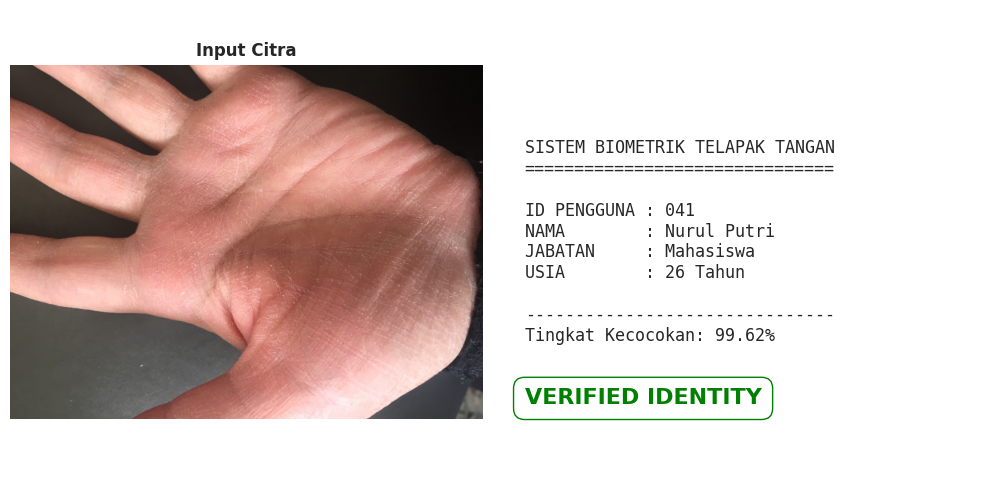

>> [LOG SISTEM] Deteksi Selesai: Nurul Putri (041)


In [ ]:
# Ganti dengan path file yang ada di laptop Anda
file_tes = r"/content/drive/MyDrive/Dataset_BMPD/Dataset_BMPD/041/041_F_L_32.JPG"

cek_identitas_lengkap(file_tes)